# Titanic Data Investigation#

_ by [Jens Laufer](mailto:jenslaufer@gmail.com) _

12 January 2017

## Introduction

The Titanic was a british passenger line that sunk on his maiden voyage on 15 April 1912. 

At about 11 pm on Sunday 14 April 1912, the ship hit an iceberg and and sank about 2.5 hours later with the loss of almost 1500 lives. One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. 

Although tragedy was not the largest in history the disaster still fascinates the people today. This is due the fact that the ship was the largest and most luxurios ever build and was considered to be unsinkable. The wreck of the ship couldn't be found till 1985 and lies in 12,000 feet (3,700 m) below the surface. [1]

Within this investigation I am using a dataset, I downloaded from [Kaggle](https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic). The dataset of study contains demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. Based on the dataset I am trying to answer several questions.

## Questions on data ##

   - Was it more likely to survive as woman or a child?
   - Was ist more likely to survive as first class passenger, because of the socioeconomic status?
   - Was ist more likely to survive on the different locations of embarkment?
   - Was ist more like to survive as a family member or a person on his own?   
   - Was ist more like to survive in certain Age groups?   

In [767]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from scipy import stats

sns.set(style="whitegrid")

filename = 'titanic-data.csv'
titanic_df = pd.read_csv(filename)

## About the dataset ##

### Structure of dataset ###

|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked
|-|-|-|-|-|-|-|-|-|-|-|
|Passenger Id|Survival (0 = No; 1 = Yes)|Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)|Name|Sex|Age|Number of Siblings/Spouses Aboard|Number of Parents/Children Aboard|Ticket Number|Passenger Fare|Cabin|Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

#### Example data ####

In [768]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##  Data Analysis: Data Cleaning and Wrangling ##

In [769]:
titanic_df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

I found out that data is missing in some columns:

Not for all passengers the 'Age' is available

Not for all passengers 'Cabin' available.

Not for all passengers 'Embarked' is available.

### Dealing with missing Age

I am filling the missing ages with the mean age of the passenger's class and gender.

In [770]:
# we add the mean of the Age for all missing ages
def fill_na_ages(row):
    age = row['Age']
    sex = row['Sex']
    p_class = row['Pclass']
    if age != age:
        return titanic_df.groupby(['Sex','Pclass'])['Age'].mean()[sex, p_class]
    else:
        return age

titanic_df['Age'] = titanic_df.apply(fill_na_ages, axis=1)

### Dealing with missing Cabin Data

I am not interested in the exact cabin passengers stayed in, I am rather interested on which deck they had been on the ship.
The first letter of the cabin indicates the deck the cabin was on. I am extracting this deck information and creating a new dataset with just the deck for each passenger the deck is available for. I am using a second dataset as there are much less cabin/deck entries than for other fields in the main dataset. Therefore I want to seperate it from the main dataset. 

In [771]:
def get_deck(cabin):
    if cabin == cabin:
        return cabin[0:1]
    return cabin
deck_titanic_df = pd.DataFrame(titanic_df['PassengerId'])
deck_titanic_df['Deck'] = titanic_df.Cabin.apply(get_deck)
deck_titanic_df = deck_titanic_df.dropna(subset=['Deck'])

In [772]:
deck_titanic_df.groupby('Deck').Deck.count()

Deck
A    15
B    47
C    59
D    33
E    32
F    13
G     4
T     1
Name: Deck, dtype: int64

In [773]:
deck_titanic_df.merge(titanic_df, on='PassengerId', how='inner')[deck_titanic_df.merge(titanic_df, on='PassengerId', how='inner').Deck == 'T']

,PassengerId,Deck,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
78,340,T,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S


There might be a problem with the decks, as there is just one entry for deck 'T'. 

I researched the web and found out that the Deck 'T' was the boat deck. There was only one single first class cabin on this deck next to the lifeboats. This cabins seems a very special cabin therefore I am deleting the entry.

[Titanic Cabins](https://www.encyclopedia-titanica.org/cabins.html)

In [774]:
deck_titanic_df = deck_titanic_df[deck_titanic_df.Deck != 'T']

### Dealing with missing Embarkments

I am checking where embarkment is missing:

In [775]:
titanic_df[titanic_df.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


I am checking if there are other passengers with either the same ticket or the same cabin:

In [776]:
titanic_df[titanic_df.Embarked.notnull() & ((titanic_df.Cabin == 'B28') | (titanic_df.Ticket == '113572'))]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


Unfortunately I could not find more passengers with the same ticket or the same cabin.
As the name of the passengers sound English they most probably either boarded in Southampton or Queenstown.

In [777]:
titanic_df[(titanic_df.Embarked == 'S') | (titanic_df.Embarked == 'Q')].groupby('Embarked')['Embarked'].count()

Embarked
Q     77
S    644
Name: Embarked, dtype: int64

As many more passengers boarded in Southampton than in Queenstown chances are quiet high these people boarded in Southampton.

Researching the web I found this:

[Stone, Mrs. George Nelson (Martha Evelyn)](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html) boarded in Southampton.

[Icard, Miss. Amelie](https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html) boarded in Southampton.


I change the Embarked to 'S' for these two passengers.

In [778]:
titanic_df.set_value(61, 'Embarked', 'S');
titanic_df.set_value(829, 'Embarked', 'S');

### Removal of unused columns and addition of new columns with modified data

I am removing the columns 'Name', 'Ticket', 'Cabin' and 'Fare'  as I do not need them to answer my questions.

I am extracting a new field 'IsFamilyMember' that indicates, if someone is a family member based on the 'Parch'  and 'SibSp'. I am removing those two fields afterwards.

I am extracting different age groups and put the result into a new field 'AgeGroups'.

For convenience I am also adding a new column 'IsChild' although the information is also available in 'AgeGroups'.

I am removing 'Age' after extracting 'IsChild' and 'AgeGroups'

In [779]:
del titanic_df['Name']
del titanic_df['Ticket']
del titanic_df['Fare']
del titanic_df['Cabin']

I change the embarkement location to a full name to make it more readable:

In [780]:
def get_embarked_fullname(row):
    embarked = row['Embarked']
    if embarked == 'S':
        return 'Southampton'
    elif embarked == 'C':
        return 'Cherbourg'
    elif embarked == 'Q':
        return 'Queenstown'
    else:
        return embarked
    
titanic_df['Embarked'] = titanic_df.apply(get_embarked_fullname, axis=1)

I define a new column 'IsFamily' member: A passenger is a family member if either SibSp or Parch is > 0

In [781]:
def is_family_member(row):
    return not(row['Parch'] == 0 and row['SibSp'] == 0)

# I add a new column to the dataset
titanic_df['IsFamilyMember'] = titanic_df.apply(is_family_member, axis=1)

# I remove the Parch and SibSp columns
del titanic_df['Parch']
del titanic_df['SibSp']

I extract different age groups:

In [782]:
def age_group(row):
    age = row['Age']
    if age < 1:
        return 'Infant'
    elif age >= 1 and age <= 9:
        return 'Child'
    elif age > 9 and age <= 19:
        return 'Adolescent'
    elif age > 19 and age <= 45:
        return 'Adult'
    elif age > 45 and age <= 60:
        return 'Middle Age'
    elif age > 60:
        return 'Senior'
    else:
        return age

titanic_df['AgeGroup'] = titanic_df.apply(age_group, axis=1)

I extract as well, if a passenger is a child:

In [783]:
def is_child(row):
    age = row['Age']
    if age <= 14:
        return True
    elif age > 14:
        return False
    else:
        return age

titanic_df['IsChild'] = titanic_df.apply(is_child, axis=1)

In [784]:
# I delete the Age column
del titanic_df['Age']

#### Wrangled Data ####

In [785]:
titanic_df.count()

PassengerId       891
Survived          891
Pclass            891
Sex               891
Embarked          891
IsFamilyMember    891
AgeGroup          891
IsChild           891
dtype: int64

In [786]:
titanic_df.head()

,PassengerId,Survived,Pclass,Sex,Embarked,IsFamilyMember,AgeGroup,IsChild
0,1,0,3,male,Southampton,True,Adult,False
1,2,1,1,female,Cherbourg,True,Adult,False
2,3,1,3,female,Southampton,False,Adult,False
3,4,1,1,female,Southampton,True,Adult,False
4,5,0,3,male,Southampton,False,Adult,False


In [787]:
deck_titanic_df.count()

PassengerId    203
Deck           203
dtype: int64

In [788]:
deck_titanic_df.head()

,PassengerId,Deck
1,2,C
3,4,C
6,7,E
10,11,G
11,12,C


## Data Analysis: Answering the questions ##

Survival Probability of all passengers in the dataset:

In [789]:
titanic_df['Survived'].mean()

0.3838383838383838

###  Was it more likely to survive as a woman or a child? ###

#### Hypothesis

$H_0$: Gender does not have an impact on the survival probabilty


$H_A$: Gender does have an impact on the survival probabilty

I chose $\alpha = .05$

#### Hypothesis Test

In [790]:
table = pd.crosstab([titanic_df['Survived']], [titanic_df['Sex']])
chi2, p, dof, expected = stats.chi2_contingency(table.values)

print chi2
print p

260.717020167
1.19735706278e-58


$\chi^2 = 260.717020167$

$p = 1.19735706278e-58$

I reject  $H_0$  as p < .0001. Gender has a great impact on the survival probability.

#### Hypothesis

$H_0$: Being a child does not have an impact on the survival probabilty


$H_A$: Being a child does have an impact on the survival probabilty

I chose $\alpha = .05$

##### Hyphothesis Test

In [791]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['IsChild'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)

print chi2
print p

13.4239115317
0.00024843712818


$\chi^2 = 13.4239115317$

$p = 0.00024843712818$

I reject $H_0$ as p < .001. Being a child has an impact on the survival probability.

I am analyzing the data of all female passengers:

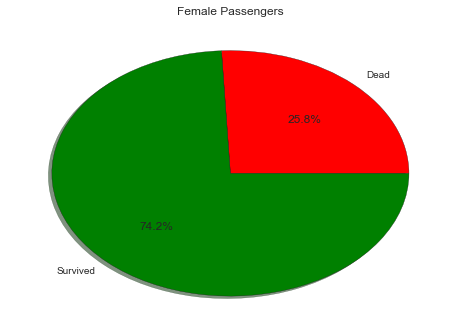

In [823]:
vals = titanic_df[titanic_df.Sex == 'female'].groupby('Survived').Sex.count()
plt.pie(vals, labels=['Dead','Survived'], colors=['red', 'green'], autopct='%1.1f%%', shadow=True)
plt.title("Female Passengers")
plt.show()

74.2% of all female passengers survived the disaster.

I am analyzing the data of all male passengers:

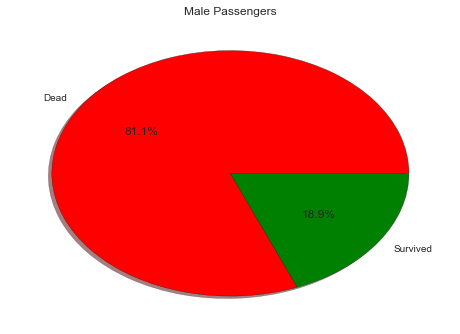

In [793]:
vals = titanic_df[titanic_df.Sex == 'male'].groupby('Survived').Sex.count()
plt.pie(vals, labels=['Dead','Survived'], colors=['red', 'green'], autopct='%1.1f%%', shadow=True)
plt.title("Male Passengers")
plt.show()

The survival probability of the female passengers (74.2%) in the dataset is higher than the overall survival rate (38.4%) and higher than the survival rate of the male passengers (18.9%). 

Now I am analyzing the data of all children on the Titanic:

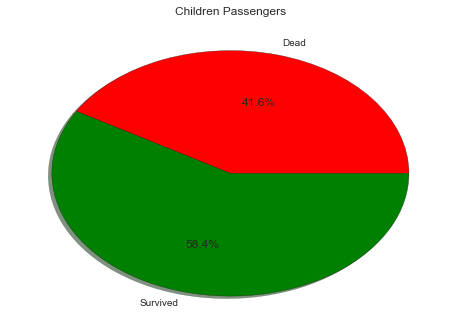

In [824]:
vals = titanic_df[titanic_df.IsChild == True].groupby('Survived').Sex.count()
plt.pie(vals, labels=['Dead','Survived'], colors=['red', 'green'], autopct='%1.1f%%', shadow=True)
plt.title("Children Passengers")
plt.show()

The survival probability of children (58.4%) was higher than the rest of the passengers (36.5%) and the overall survival rate(38.4%).

#### Result ####

On the Titanic existed most probably a ["Women and children first" code of conduct](https://en.wikipedia.org/wiki/Women_and_children_first) when the ship was evacuated as the survival probability was higher for woman and children.

### Was ist more likely to survive as first class passenger, because of the socioeconomic status? ###

Survival rate by passenger class

In [795]:
titanic_df.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

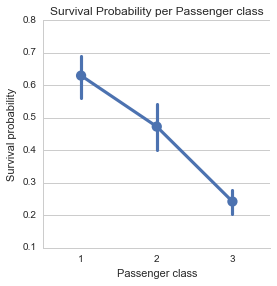

In [796]:
chart = sns.factorplot(x = 'Pclass', y ='Survived', data = titanic_df)
chart.set(title='Survival Probability per Passenger class', ylabel='Survival probability', xlabel='Passenger class')
sns.plt.show()

The survival probabilty of first class passengers was higher than for the second and third class.

Were the first class passengers rescued, because of their socioeconomic status or were other factors responsible for the higher survival probability?

   * Have the first class cabins been on top of the ship and were the passengers of these cabins rescued first?
   * Have there been more female passengers or children in the first class?

#### Have the first class cabins been on top of the ship and were the passengers of these cabins rescued first?

##### Where are the cabins of each passenger class located?

###### Titanic deck layout

![Titanic deck layout](https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Titanic_cutaway_diagram.png/400px-Titanic_cutaway_diagram.png "Titanic deck layout")

In [797]:
merged = deck_titanic_df.merge(titanic_df, on=['PassengerId'], how='inner')[['Deck', 'Survived', 'Pclass', 'Sex']]

In [798]:
merged.groupby(['Pclass']).Survived.count()

Pclass
1    175
2     16
3     12
Name: Survived, dtype: int64

I will ignore the deck information for the second and third class as there are not enough data available for these classes and the cabins of the first class passengers were located on the decks A-E. With this information I should be able to evaluate, if the ship was rescued in a certain order.

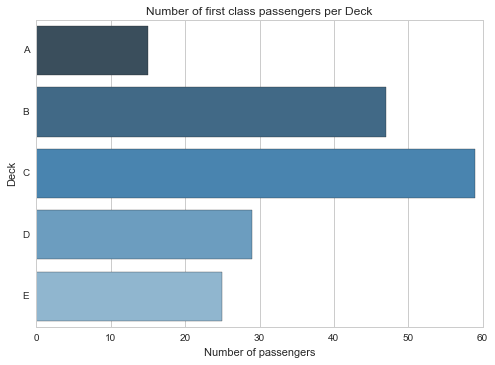

In [799]:
plot = sns.countplot(y="Deck", data=merged[merged['Pclass'] == 1].sort_values(by='Deck'), palette= 'Blues_d')
plot.set(title='Number of first class passengers per Deck', ylabel='Deck', xlabel='Number of passengers')
sns.plt.show()

In [800]:
merged[merged['Pclass'] == 1].groupby(['Pclass','Deck']).Survived.mean().sort_values()

Pclass  Deck
1       A       0.466667
        C       0.593220
        E       0.720000
        B       0.744681
        D       0.758621
Name: Survived, dtype: float64

The cabins of the first class were located on the decks A-E. If there would have been a rescue plan from the top to the bottom there would be a higher survival on deck A than e.g. on deck D. I can actually see that the survival probability on deck D and E was higher than on deck A. On the other hand was survival probabilty on deck B the second highest. It seems that the passengers on top of ship were not rescued first.

Interesting is the fact that the survival on deck C was quiet low in compare to the other decks. A reason could be a panic as on this deck as there might have been more passengers. But we don't have data of all passengers on the Titanic. This could be investigated further.


I want to evaluate now, if there were more female passengers in the first class than in other classes:

In [801]:
female_ratio_per_class = titanic_df[titanic_df['Sex'] == "female"].groupby(['Pclass']).PassengerId.count() / titanic_df.groupby(['Pclass']).PassengerId.count()
female_ratio_per_class

Pclass
1    0.435185
2    0.413043
3    0.293279
Name: PassengerId, dtype: float64

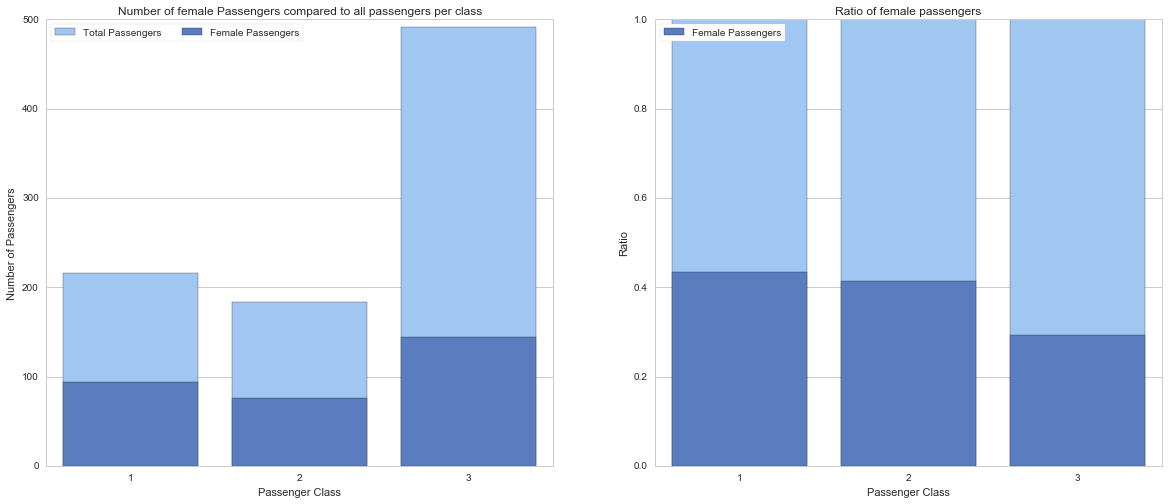

In [802]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))

sns.set_color_codes("pastel")
sns.barplot(x=titanic_df.Pclass.value_counts().index, ax=ax1, y=titanic_df.Pclass.value_counts(),
            label="Total Passengers", color="b", order=[1,2,3])

sns.set_color_codes("muted")
sns.barplot(x=titanic_df.Pclass.value_counts().index, ax=ax1, y=titanic_df[titanic_df.Sex == 'female'].Pclass.value_counts(),
            label="Female Passengers", color="b", order=[1,2,3])


sns.set_color_codes("pastel")
sns.barplot(x=titanic_df.Pclass.value_counts().index, ax=ax2, y=[1,1,1], color="b")
sns.set_color_codes("muted")
sns.barplot(x=female_ratio_per_class.sort_values().index, ax=ax2, y=female_ratio_per_class.sort_values(),
           label="Female Passengers", color="b", order=[1,2,3])

ax1.legend(ncol=2, loc="upper left", frameon=True)
ax1.set(title="Number of female Passengers compared to all passengers per class", ylabel="Number of Passengers",
       xlabel="Passenger Class")

ax2.legend(ncol=2, loc="upper left", frameon=True)
ax2.set(title="Proportion of female passengers", ylabel="Ratio",
       xlabel="Passenger Class")

sns.plt.show()

Indeed was the proportion of female passengers slightly higher than in the second class and much higher than in third class. 

Was there more children in the first class than in the other passenger classes:

In [803]:
children_ratio_per_class = titanic_df[titanic_df['IsChild'] == True].groupby(['Pclass']).PassengerId.count() / titanic_df.groupby(['Pclass']).PassengerId.count()
children_ratio_per_class

Pclass
1    0.023148
2    0.103261
3    0.107943
Name: PassengerId, dtype: float64

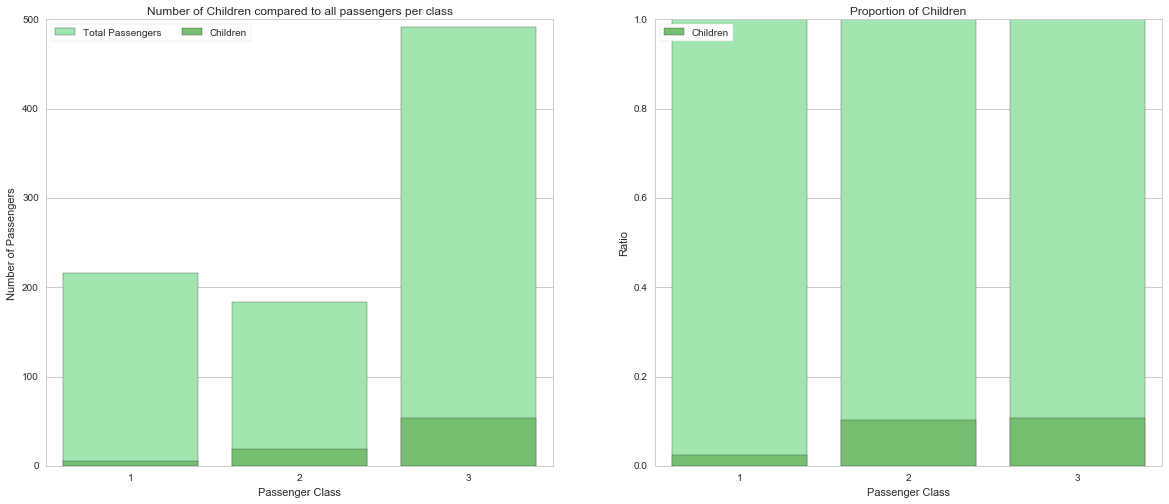

In [825]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))

sns.set_color_codes("pastel")
sns.barplot(x=titanic_df.Pclass.value_counts().index, ax=ax1, y=titanic_df.Pclass.value_counts(),
            label="Total Passengers", color="g")

sns.set_color_codes("muted")
sns.barplot(x=titanic_df[titanic_df.IsChild == True].Pclass.value_counts().index, ax=ax1, y=titanic_df[titanic_df.IsChild == True].Pclass.value_counts(),
            label="Children", color="g")


sns.set_color_codes("pastel")
sns.barplot(x=titanic_df.Pclass.value_counts().index, ax=ax2, y=[1,1,1], color="g")
sns.set_color_codes("muted")
sns.barplot(x=children_ratio_per_class.sort_values().index, ax=ax2, y=children_ratio_per_class.sort_values(),
           label="Children", color="g")

ax1.legend(ncol=2, loc="upper left", frameon=True)
ax1.set(title="Number of Children compared to all passengers per class", ylabel="Number of Passengers",
       xlabel="Passenger Class")

ax2.legend(ncol=2, loc="upper left", frameon=True)
ax2.set(title="Proportion of Children", ylabel="Ratio",
       xlabel="Passenger Class")

sns.plt.show()

The proportion of children in the third class was much higher that in the first class.

#### Result ####

The Survival probability of first class passengers was the highest (63.0%). On the other hand the third class had a very low probability of surviving the disaster (24.2%). This is most probably due the fact, that first class passengers where rescued because of their socioeconomic status and not due the fact that there had been more children  or that the first class cabins were on the top of the ship and these decks were rescued first.

There had been more female passengers in the first class, which had a positive influence on the survival probabilty.


### Was ist more likely to survive on the different locations of embarkment? ###

#### Hypothesis

$H_0$: Embarkment location does not have an impact on the survival probabilty


$H_A$: Embarkment location does have an impact on the survival probabilty
    

I chose $\alpha = .05$

#### Hypothesis Test

In [805]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['Embarked'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)

print chi2
print p    

25.9644528819
2.30086264814e-06


$\chi^2 = 26.4891498392$

$p = 1.76992228412e-06$

I reject $H_0$ as p < .0001. Embarkment has an impact on the survival probability.

I am examining the survival rate by embarkement location:

In [826]:
titanic_df.groupby('Embarked')['Survived'].mean()

Embarked
Cherbourg      0.553571
Queenstown     0.389610
Southampton    0.339009
Name: Survived, dtype: float64

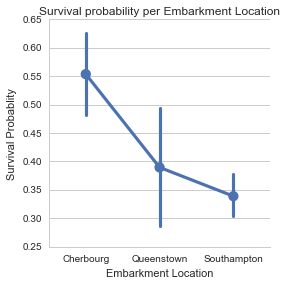

In [807]:
plot = sns.factorplot(x = 'Embarked', y = 'Survived', data = titanic_df, kind='point', order=['Cherbourg', 'Queenstown', 'Southampton'])
plot.set(title='Survival probability per Embarkment Location', ylabel='Survival Probablity', xlabel='Embarkment Location')
sns.plt.show()

The survival probability was higher for passengers who boarded in Cherbourg.

What factors might be responsible for that:

   - Were there more first class passengers in Cherbourg?
   - Was the proportion of children and woman higher in Cherbourg?

Passengers by embarkment location and class:

In [839]:
firstclass_ratio_per_embarkment = titanic_df[titanic_df['Pclass'] == 1].groupby(['Embarked']).PassengerId.count() / titanic_df.groupby(['Embarked']).PassengerId.count()
firstclass_ratio_per_embarkment

Embarked
Cherbourg      0.505952
Queenstown     0.025974
Southampton    0.199690
Name: PassengerId, dtype: float64

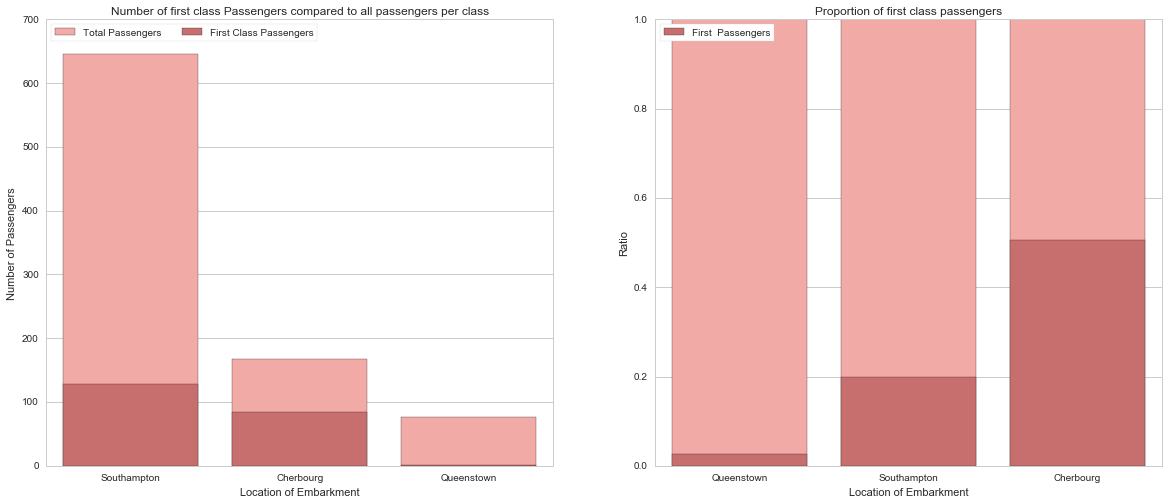

In [834]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))

sns.set_color_codes("pastel")
sns.barplot(x=titanic_df.Embarked.value_counts().index, ax=ax1, y=titanic_df.Embarked.value_counts(),
            label="Total Passengers", color="r")

sns.set_color_codes("muted")
sns.barplot(x=titanic_df.Embarked.value_counts().index, ax=ax1, y= titanic_df[titanic_df.Pclass == 1].Embarked.value_counts(),
            label="First Class Passengers", color="r")


sns.set_color_codes("pastel")
sns.barplot(x=titanic_df.Embarked.value_counts().index, ax=ax2, y=[1,1,1], color="r")
sns.set_color_codes("muted")
sns.barplot(x=firstclass_ratio_per_embarkment.sort_values().index, ax=ax2, y=firstclass_ratio_per_embarkment.sort_values(),
           label="First  Passengers", color="r")

ax1.legend(ncol=2, loc="upper left", frameon=True)
ax1.set(title="Number of first class Passengers compared to all passengers per class", ylabel="Number of Passengers",
       xlabel="Location of Embarkment")

ax2.legend(ncol=2, loc="upper left", frameon=True)
ax2.set(title="Proportion of first class passengers", ylabel="Ratio",
       xlabel="Location of Embarkment")

sns.plt.show()

The proportion of first class passengers was higher in Cherbourg than in Southampton and Queenstown.

Now I am evaluating the proportion of children for the different locations of embarkement:

In [849]:
children_ratio_per_embarkment = titanic_df[titanic_df.IsChild == True].groupby(['Embarked']).PassengerId.count() / titanic_df.groupby(['Embarked']).PassengerId.count()
children_ratio_per_embarkment

Embarked
Cherbourg      0.083333
Queenstown     0.051948
Southampton    0.091331
Name: PassengerId, dtype: float64

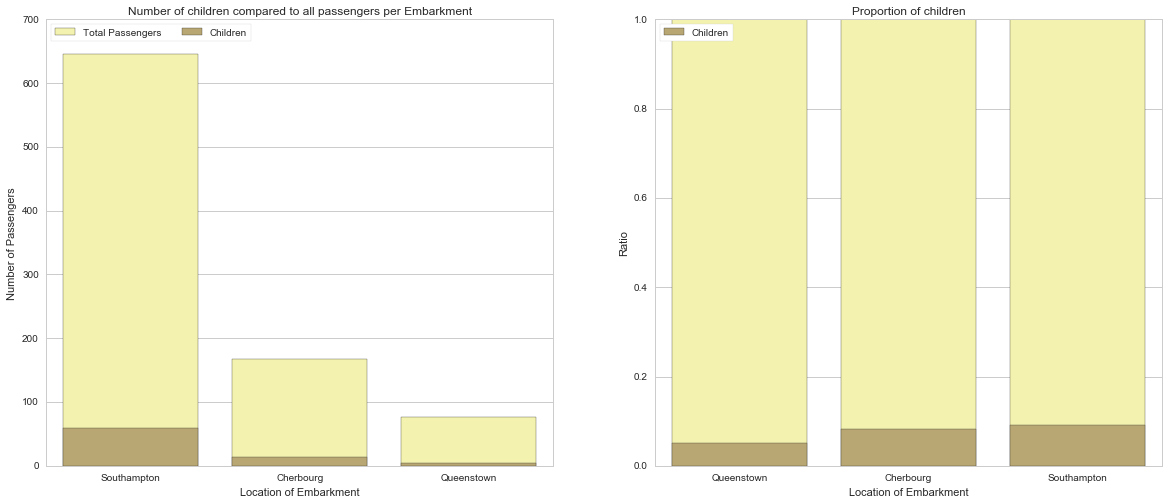

In [847]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))

sns.set_color_codes("pastel")
sns.barplot(x=titanic_df.Embarked.value_counts().index, ax=ax1, y=titanic_df.Embarked.value_counts(),
            label="Total Passengers", color="y")

sns.set_color_codes("muted")
sns.barplot(x=titanic_df.Embarked.value_counts().index, ax=ax1, y= titanic_df[titanic_df.IsChild == True].Embarked.value_counts(),
            label="Children", color="y")


sns.set_color_codes("pastel")
sns.barplot(x=titanic_df.Embarked.value_counts().index, ax=ax2, y=[1,1,1], color="y")
sns.set_color_codes("muted")
sns.barplot(x=children_ratio_per_embarkment.sort_values().index, ax=ax2, y=children_ratio_per_embarkment.sort_values(),
           label="Children", color="y")

ax1.legend(ncol=2, loc="upper left", frameon=True)
ax1.set(title="Number of children compared to all passengers per Embarkment", ylabel="Number of Passengers",
       xlabel="Location of Embarkment")

ax2.legend(ncol=2, loc="upper left", frameon=True)
ax2.set(title="Proportion of children", ylabel="Ratio",
       xlabel="Location of Embarkment")

sns.plt.show()

The proportion of children was about the same in Cherbourg, Queenstown and Southampton

In [850]:
female_ratio_per_embarkment = titanic_df[titanic_df.Sex == 'female'].groupby(['Embarked']).PassengerId.count() / titanic_df.groupby(['Embarked']).PassengerId.count()
female_ratio_per_embarkment

Embarked
Cherbourg      0.434524
Queenstown     0.467532
Southampton    0.317337
Name: PassengerId, dtype: float64

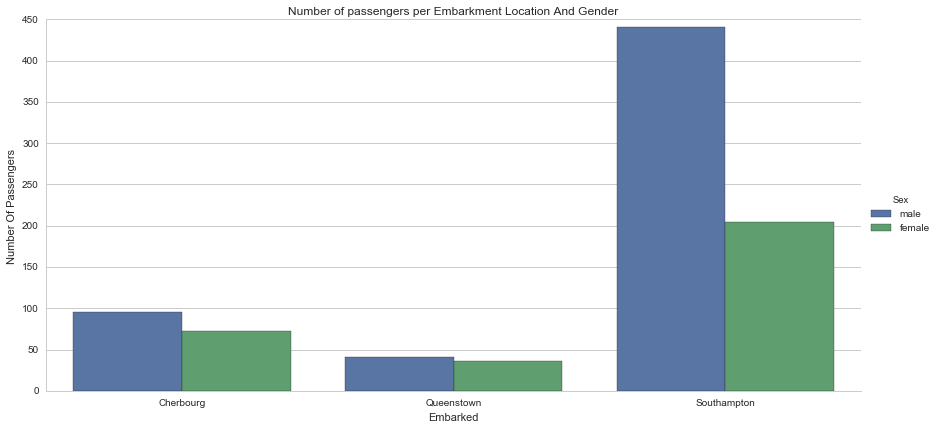

In [812]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))

sns.set_color_codes("pastel")
sns.barplot(x=titanic_df.Embarked.value_counts().index, ax=ax1, y=titanic_df.Embarked.value_counts(),
            label="Total Passengers", color="o")

sns.set_color_codes("muted")
sns.barplot(x=titanic_df.Embarked.value_counts().index, ax=ax1, y= titanic_df[titanic_df.Sex == 'female'].Embarked.value_counts(),
            label="Female passengers", color="y")


sns.set_color_codes("pastel")
sns.barplot(x=titanic_df.Embarked.value_counts().index, ax=ax2, y=[1,1,1], color="y")
sns.set_color_codes("muted")
sns.barplot(x=female_ratio_per_embarkment.sort_values().index, ax=ax2, y=female_ratio_per_embarkment.sort_values(),
           label="Female passengers", color="y")

ax1.legend(ncol=2, loc="upper left", frameon=True)
ax1.set(title="Number of Female passengers compared to all passengers per Embarkment", ylabel="Number of Passengers",
       xlabel="Location of Embarkment")

ax2.legend(ncol=2, loc="upper left", frameon=True)
ax2.set(title="Proportion of Female passengers", ylabel="Ratio",
       xlabel="Location of Embarkment")

sns.plt.show()

The proportion of woman was about the same in Cherbourg, Queenstown and Southampton

#### Result ####

The probabilty of surviving the titanic disaster was highest in case someone boarded in Cherbourg.
This is most probably due the fact that the proportion of first class passengers from Cherbourg was higher than in Southampton and Queenstown and not due the fact that in Cherborug the propportion of woman or children were higher.

### Was ist more like to survive as a family member or a person on his own? ###

#### Hypothesis

$H_0$: Being a family member does not have an impact on the survival probabilty


$H_A$:  Being a family member does have an impact on the survival probabilty
    

I chose $\alpha = .05$

#### Hypothesis Test

In [813]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['IsFamilyMember'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)

print chi2
print p   

36.0005144677
1.97265438465e-09


$\chi^2 = 36.0005144677$

$p = 1.97265438465e-09$

I reject $H_0$ as p < .0001. Being a family member has an impact on the survival probability.

In [814]:
titanic_df.groupby('IsFamilyMember')['Survived'].mean()

IsFamilyMember
False    0.303538
True     0.505650
Name: Survived, dtype: float64

In [815]:
titanic_df.groupby(['Pclass','IsFamilyMember'])['Survived'].mean()

Pclass  IsFamilyMember
1       False             0.532110
        True              0.728972
2       False             0.346154
        True              0.637500
3       False             0.212963
        True              0.299401
Name: Survived, dtype: float64

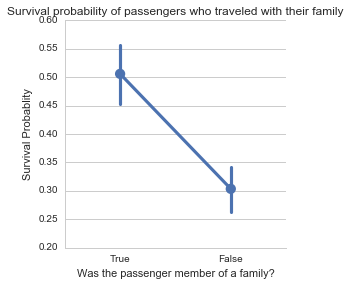

In [816]:
plot = sns.factorplot(x = 'IsFamilyMember', y = 'Survived', data = titanic_df, kind='point', order=[True, False])
plot.set(title='Survival probability of passengers who traveled with their family', ylabel='Survival Probablity', xlabel='Was the passenger member of a family?')
sns.plt.show()

#### Result

The probabilty of surviving the Titanic disaster was higher as member of a family than a person on his own in the first and second class. This is most probably also due the ["Women and children first" code of conduct](https://en.wikipedia.org/wiki/Women_and_children_first). In the third class the chance to survive the titanic disaster for person on his own and a family member was about the same.

### Survival by Age Group

#### Hypothesis

$H_0$: Age Group does not have an impact on the survival probabilty


$H_A$: Age Group does have an impact on the survival probabilty
    

I chose $\alpha = .05$

#### Hypothesis Test

In [817]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['AgeGroup'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)

print chi2
print p   

22.7943350827
0.000369533449617


$\chi^2 = 22.7943350827$

$p = 0.000369533449617$

I reject $H_0$ as p < .001. Age Group has an impact on the survival probability.

In [818]:
titanic_df.groupby('AgeGroup')['Survived'].count().sort_values()

AgeGroup
Infant          7
Senior         22
Child          55
Middle Age     81
Adolescent    102
Adult         624
Name: Survived, dtype: int64

In [819]:
titanic_df.groupby('AgeGroup')['Survived'].mean().sort_values()

AgeGroup
Senior        0.227273
Adult         0.360577
Adolescent    0.401961
Middle Age    0.407407
Child         0.563636
Infant        1.000000
Name: Survived, dtype: float64

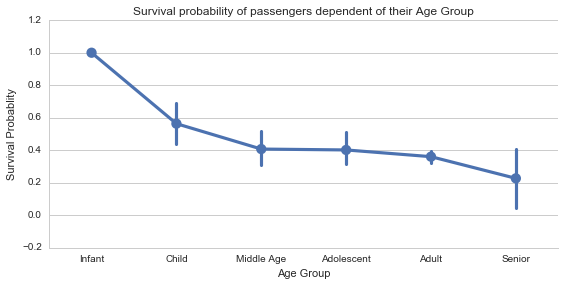

In [820]:
plot = sns.factorplot(x = 'AgeGroup', y = 'Survived', data = titanic_df, kind='point', order=['Infant', 'Child', 'Middle Age', 'Adolescent', 'Adult', 'Senior'], size=4, aspect=2)
plot.set(title='Survival probability of passengers dependent of their Age Group', ylabel='Survival Probablity', xlabel='Age Group')
sns.plt.show()

In [821]:
titanic_df[titanic_df.AgeGroup.isin(['Infant', 'Child'])].groupby(['Pclass', 'AgeGroup']).Survived.count()

Pclass  AgeGroup
1       Child        2
        Infant       1
2       Child       14
        Infant       3
3       Child       39
        Infant       3
Name: Survived, dtype: int64

In [822]:
titanic_df[titanic_df.AgeGroup.isin(['Infant', 'Child'])].groupby(['Pclass', 'AgeGroup']).Survived.mean()

Pclass  AgeGroup
1       Child       0.500000
        Infant      1.000000
2       Child       1.000000
        Infant      1.000000
3       Child       0.410256
        Infant      1.000000
Name: Survived, dtype: float64

#### Result

The probability of surviving the Titanic disaster was higher for children than for other age groups. The lowest chance of surviving the sinking of the ship had adults and seniors. 

Interesting is also that all 7 infants survived the disaster, even the 3 infants from the third class. In the first and second class all children survived apart from one child in the first class. She was Loraine Allison: Loraines parents decided to stay on the ship as Loraines brother was missing with his nurse.[2]

## Appendix A

### Sources

[1] [https://en.wikipedia.org/wiki/RMS_Titanic](https://en.wikipedia.org/wiki/RMS_Titanic)

[2] [https://www.encyclopedia-titanica.org/titanic-victim/loraine-allison.html](https://www.encyclopedia-titanica.org/titanic-victim/loraine-allison.html)